In [1]:
import prettytensor as pt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

In [6]:
combined_images = np.concatenate([data.train.images, data.validation.images], axis=0)
combined_labels = np.concatenate([data.train.labels, data.validation.labels], axis=0)

In [7]:
combined_size = len(combined_images)
print(combined_size)

60000


In [8]:
train_size = int(combined_size * 0.8)
validation_size = combined_size - train_size
print(validation_size)

12000


In [9]:
def random_training_set(combined_images, combined_labels, rate=0.8):
    combined_size = len(combined_images)
    idx = np.random.permutation(combined_size)
    
    train_size = int(combined_size * rate)
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]
    
    x_train = combined_images[idx_train, :]
    y_train = combined_labels[idx_train, :]
    
    x_validation = combined_images[idx_validation, :]
    y_validation = combined_images[idx_validation, :]
    
    return x_train, y_train, x_validation, y_validation

In [10]:
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [11]:
def plot_images(images,
                cls_true,
                ensemble_cls_pred = None,
                best_cls_pred = None
               ):
    assert len(images) == len(cls_true)
    
    fig, axes = plt.subplots(3, 3)
    
    if ensemble_cls_pred is None:
        hspace = 0.3
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace = hspace, wspace=0.3)    
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].reshape(img_shape), cmap='binary')
            
            if ensemble_cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
                
            else:
                msg = "True: {0}\nEnsemble: {1}\nBest Net: {2}"
                xlabel = msg.format(cls_true[i],
                                    ensemble_cls_pred[i],
                                    best_cls_pred[i]
                                   )
            ax.set_xlabel(xlabel)
            
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

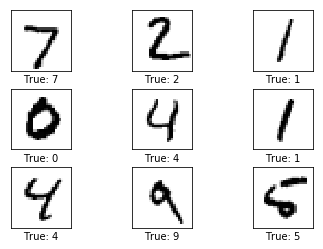

In [12]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images = images, cls_true=cls_true)

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [14]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [15]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

In [16]:
y_true_cls = tf.argmax(y_true, axis=1)

In [17]:
x_pretty = pt.wrap(x_image)

In [18]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
    conv2d(kernel=5, depth=16, name='conv1').\
    max_pool(kernel=2, stride=2).\
    conv2d(kernel=5, depth=36, name='conv2').\
    max_pool(kernel=2, stride=2).\
    flatten().\
    fully_connected(size=128, name='fc1').\
    softmax_classifier(num_classes=num_classes, labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [20]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
saver = tf.train.Saver(max_to_keep=100)
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [23]:
def get_save_path(net_number):
    return save_dir + 'network' + str(net_number)

In [24]:
session = tf.Session()

In [25]:
def init_variables():
    session.run(tf.initialize_all_variables())

In [26]:
train_batch_size = 64

In [27]:
num_networks = 5
num_iterations = 10000

In [28]:
x_train, y_train, x_validation, y_validation = random_training_set(combined_images, combined_labels, rate=0.8)

In [29]:
def random_batch(x_train, y_train, net_id):
    # Total number of images in the training-set.
    
    block_size = int(len(x_train) / num_networks)
    
    smaple_idx = np.arange(net_id * block_size, (net_id+1) * block_size)
    num_images = len(smaple_idx)
    
    #print(smaple_idx)
    
    # Create a random index into the training-set.
    idx = np.random.choice(smaple_idx,
                           size=train_batch_size,
                           replace=False)
    #print(idx)
    # Use the random index to select random images and labels.
    x_batch = x_train[idx, :]  # Images.
    y_batch = y_train[idx, :]  # Labels.

    # Return the batch.
    return x_batch, y_batch

In [30]:
xx, yy = random_batch(x_train, y_train, net_id=1)
print(xx.shape)

(64, 784)


In [31]:

def optimize(num_iterations, x_train, y_train, net_id):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(x_train, y_train, net_id)

        #print(x_batch.shape)
        #print(y_true_batch.shape)
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if i % 1000 == 0:

            # Calculate the accuracy on the training-batch.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Status-message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Batch Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [32]:
checkpoint_dir = './checkpoints'
print(checkpoint_dir)
print(os.path.exists(checkpoint_dir))
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
print(ckpt)
print(ckpt.all_model_checkpoint_paths)
print(ckpt.model_checkpoint_path)

./checkpoints
True
model_checkpoint_path: "./checkpoints\\network49"
all_model_checkpoint_paths: "./checkpoints\\network0"
all_model_checkpoint_paths: "./checkpoints\\network1"
all_model_checkpoint_paths: "./checkpoints\\network2"
all_model_checkpoint_paths: "./checkpoints\\network3"
all_model_checkpoint_paths: "./checkpoints\\network4"
all_model_checkpoint_paths: "./checkpoints\\network5"
all_model_checkpoint_paths: "./checkpoints\\network6"
all_model_checkpoint_paths: "./checkpoints\\network7"
all_model_checkpoint_paths: "./checkpoints\\network8"
all_model_checkpoint_paths: "./checkpoints\\network9"
all_model_checkpoint_paths: "./checkpoints\\network10"
all_model_checkpoint_paths: "./checkpoints\\network11"
all_model_checkpoint_paths: "./checkpoints\\network12"
all_model_checkpoint_paths: "./checkpoints\\network13"
all_model_checkpoint_paths: "./checkpoints\\network14"
all_model_checkpoint_paths: "./checkpoints\\network15"
all_model_checkpoint_paths: "./checkpoints\\network16"
all_mo

In [33]:
if ckpt and len(ckpt.model_checkpoint_path) == num_networks:
    print("find trained param, jump the training process")
    checkpoint_dir = './checkpoints'

else:
    # For each of the neural networks.
    for i in range(num_networks):
        print("Neural network: {0}".format(i))

        # Create a random training-set. Ignore the validation-set.
        #x_train, y_train, _, _ = random_training_set(combined_images, combined_labels, net_id= i )

        # Initialize the variables of the TensorFlow graph.
        session.run(tf.global_variables_initializer())

        # Optimize the variables using this training-set.
        optimize(num_iterations=num_iterations,
                 x_train=x_train,
                 y_train=y_train,
                 net_id=i)

        # Save the optimized variables to disk.
        saver.save(sess=session, save_path=get_save_path(i))

        # Print newline.
        print()

Neural network: 0
Optimization Iteration:      1, Training Batch Accuracy:  15.6%
Optimization Iteration:   1001, Training Batch Accuracy:  98.4%
Optimization Iteration:   2001, Training Batch Accuracy: 100.0%
Optimization Iteration:   3001, Training Batch Accuracy: 100.0%
Optimization Iteration:   4001, Training Batch Accuracy: 100.0%
Optimization Iteration:   5001, Training Batch Accuracy: 100.0%
Optimization Iteration:   6001, Training Batch Accuracy: 100.0%
Optimization Iteration:   7001, Training Batch Accuracy: 100.0%
Optimization Iteration:   8001, Training Batch Accuracy: 100.0%
Optimization Iteration:   9001, Training Batch Accuracy: 100.0%
Time usage: 0:01:25

Neural network: 1
Optimization Iteration:      1, Training Batch Accuracy:  26.6%
Optimization Iteration:   1001, Training Batch Accuracy:  96.9%
Optimization Iteration:   2001, Training Batch Accuracy: 100.0%
Optimization Iteration:   3001, Training Batch Accuracy:  98.4%
Optimization Iteration:   4001, Training Batch 

In [34]:
batch_size = 256
def predict_labels(images):
    num_images = len(images)
    pred_labels = np.zeros(shape=(num_images, num_classes), dtype=np.float)
    i=0
    
    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x : images[i:j, :]}
        pred_labels[i:j] = session.run(y_pred, feed_dict=feed_dict)
        i = j
        
    return pred_labels

In [35]:
def correct_prediction(images, labels, cls_true):
    # Calculate the predicted labels.
    pred_labels = predict_labels(images=images)

    # Calculate the predicted class-number for each image.
    cls_pred = np.argmax(pred_labels, axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct

In [36]:
def test_correct():
    return correct_prediction(images = data.test.images,
                              labels = data.test.labels,
                              cls_true = data.test.cls)

In [37]:
def validation_correct():
    return correct_prediction(images = data.validation.images,
                              labels = data.validation.labels,
                              cls_true = data.validation.cls)

In [38]:
def get_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    return correct.mean()

In [39]:
def ensemble_predictions():
    pred_labels = []
    test_accuracies = []
    val_accuracies = []
    
    for i in range(num_networks):
        saver.restore(sess=session, save_path=get_save_path(i))
        
        test_acc = get_accuracy(test_correct())
        
        test_accuracies.append(test_acc)
        
        val_acc = get_accuracy(validation_correct())
        
        val_accuracies.append(val_acc)
        
        msg = "Network: {0}, Accuracy on Validation-Set: {1: .4f}, Test-Set: {2: .4f}"
        print(msg.format(i, val_acc, test_acc))
        
        pred = predict_labels(images=data.test.images)
        
        pred_labels.append(pred)
        
    return  np.array(pred_labels), \
            np.array(test_accuracies), \
            np.array(val_accuracies)

In [40]:
pred_labels, test_accuracies, val_accuracies = ensemble_predictions()

INFO:tensorflow:Restoring parameters from checkpoints/network0
Network: 0, Accuracy on Validation-Set:  0.9880, Test-Set:  0.9839
INFO:tensorflow:Restoring parameters from checkpoints/network1
Network: 1, Accuracy on Validation-Set:  0.9836, Test-Set:  0.9815
INFO:tensorflow:Restoring parameters from checkpoints/network2
Network: 2, Accuracy on Validation-Set:  0.9848, Test-Set:  0.9839
INFO:tensorflow:Restoring parameters from checkpoints/network3
Network: 3, Accuracy on Validation-Set:  0.9866, Test-Set:  0.9833
INFO:tensorflow:Restoring parameters from checkpoints/network4
Network: 4, Accuracy on Validation-Set:  0.9850, Test-Set:  0.9820


In [41]:
ensemble_cls_labels = np.argmax(pred_labels, axis=2)
ensemble_cls_labels = ensemble_cls_labels.T
print(ensemble_cls_labels[:3])

[[7 7 7 7 7]
 [2 2 2 2 2]
 [1 1 1 1 1]]


In [42]:
ensemble_cls_labels = np.mean(pred_labels, axis=0)
ensemble_cls_pred = np.argmax(ensemble_cls_labels, axis=1)
ensemble_correct = ensemble_cls_pred == data.test.cls
ensemble_incorrect = np.logical_not(ensemble_correct)

In [43]:
test_accuracies

array([0.9839, 0.9815, 0.9839, 0.9833, 0.982 ])

In [44]:
best_net = np.argmax(test_accuracies)
print(best_net)

0


In [45]:
best_net_pred_labels = pred_labels[best_net, :, :]
best_net_cls_pred = np.argmax(best_net_pred_labels, axis=1)
best_net_correct = (best_net_cls_pred == data.test.cls)
best_net_incorrect = np.logical_not(best_net_correct)

In [46]:
np.sum(ensemble_correct)

9879

In [47]:
np.sum(best_net_correct)

9839

In [48]:
ensemble_better = np.logical_and(best_net_incorrect, ensemble_correct)
print(sum(ensemble_better))
best_net_better = np.logical_and(best_net_correct, ensemble_incorrect)
print(sum(best_net_better))

66
26


In [49]:
def get_correct_idx(correct):
    return np.arange( correct.shape[0] )[correct]

In [50]:
ensemble_better_idx = get_correct_idx(ensemble_better)
print(ensemble_better_idx)

[ 359  449  810  982 1044 1156 1182 1429 1466 1737 1913 1941 1982 2016
 2125 2168 2280 2299 2369 2560 2648 2930 2970 2979 3030 3157 3534 3574
 3702 3742 3838 3853 3869 3943 4163 4433 4443 4615 4838 4860 4886 4978
 4990 5331 5888 5922 5997 6011 6023 6059 6091 6173 6532 6576 7220 7446
 7800 7886 8246 8410 9036 9664 9679 9700 9726 9745]


In [51]:
best_net_better_idx = get_correct_idx(best_net_better)
print(best_net_better_idx)

[ 717  740 1260 1681 1717 1878 2107 2118 2293 2414 2454 3060 3475 3503
 3597 3780 3985 4065 4306 4500 4823 5600 8408 9634 9768 9856]


In [52]:
def plot_images_comparison(idx):
    plot_images(images=data.test.images[idx, :],
                cls_true=data.test.cls[idx],
                ensemble_cls_pred=ensemble_cls_pred[idx],
                best_cls_pred=best_net_cls_pred[idx])

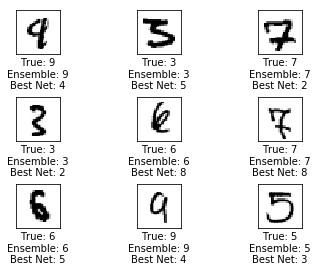

In [53]:
plot_images_comparison(ensemble_better_idx[:9])

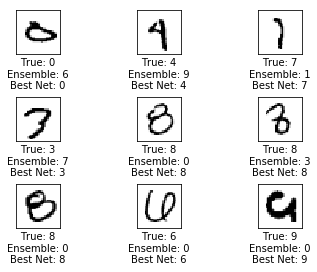

In [54]:
plot_images_comparison(best_net_better_idx[:9])

In [55]:
ensemble_incorrect_idx = get_correct_idx(ensemble_incorrect)
print(ensemble_incorrect_idx)

[ 259  321  340  445  495  582  583  613  659  684  717  740  938  947
  965 1014 1039 1112 1181 1226 1232 1247 1260 1299 1319 1326 1393 1527
 1530 1621 1681 1709 1717 1754 1878 1901 1955 2098 2107 2109 2118 2130
 2135 2182 2189 2272 2293 2387 2414 2454 2462 2488 2654 2896 2921 2927
 2939 2953 2995 3060 3073 3422 3475 3503 3520 3558 3559 3597 3767 3780
 3796 3808 3906 3985 4065 4075 4176 4224 4238 4248 4256 4306 4497 4500
 4536 4571 4639 4740 4761 4807 4823 4880 4956 5600 5887 5955 5973 6166
 6505 6597 6651 6783 7434 8094 8408 9009 9015 9019 9024 9587 9634 9642
 9729 9768 9770 9779 9811 9839 9856 9904 9982]


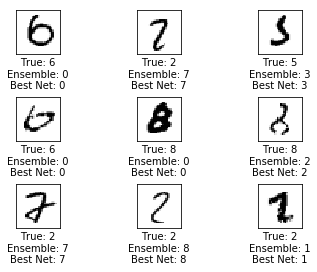

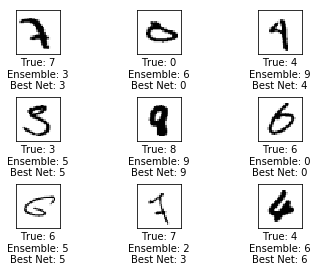

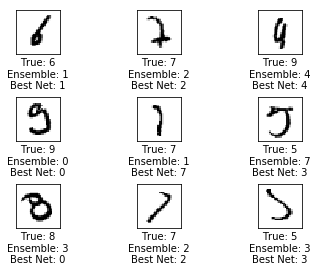

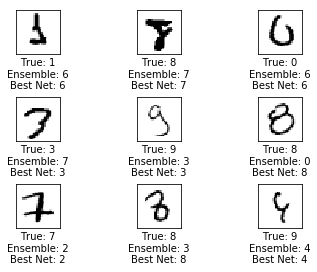

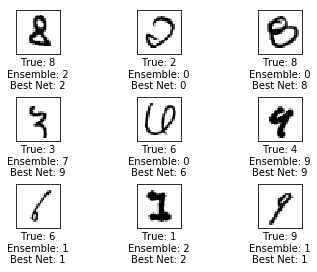

In [56]:
for i in range(0,5):
    plot_images_comparison(ensemble_incorrect_idx[i*9 : i*9 + 9])